In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [7]:
# Load road links either from network path or from the
# equilibrium assignment path
if scenario.endswith('equilibrium'):
    road = stepmodel.read_json(model_path + 'de_road_network')
else:
    road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [7]:
sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [8]:
# Load volumes
volumes_file = 'de_volumes'
v = stepmodel.read_json(model_path + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

In [9]:
# Load LoS tables with mode choice probabilities
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [10]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) for col in pt.pt_los.columns if 'probability' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [11]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [12]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
index,,,,,,,,,,,,,,,,,,,,,
4827034,DE719_5,DE246_1,"[coach, bus]","(bus_853931, bus_551219, c_7860, c_7861, c_786...",4,401551,1497,238,15600,6900,...,0.074888,0.012136,0.639069,0.24438,0.359518,0.011952,0.263426,0.01967,0.194838,0.002321


In [13]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

In [14]:
sm.car_los[[c for c in sm.car_los.columns if c[1]=='probability']].mean()

(commuting_no_car, probability)      0.005622
(commuting_car, probability)         0.910087
(business_no_car, probability)       0.191889
(business_car, probability)          0.933813
(education_no_car, probability)      0.004856
(education_car, probability)         0.669189
(buy/execute_no_car, probability)    0.009473
(buy/execute_car, probability)       0.973385
(leisure_no_car, probability)        0.011750
(leisure_car, probability)           0.949691
(accompany_no_car, probability)      0.004643
(accompany_car, probability)         0.994964
dtype: float64

In [15]:
# Create a column for car volumes
merge_cols = ['origin', 'destination']
car_vols = pd.DataFrame(index=sm.volumes.index)
for seg in sm.segments:
    merged = sm.volumes[merge_cols+[seg]].merge(
        sm.car_los[merge_cols+[(seg, 'probability')]],
        on=merge_cols,
        how='left')
    car_vols[seg] = (merged[seg] * merged[(seg, 'probability')]).fillna(0)
sm.volumes['volume_car'] = car_vols[sm.segments].sum(axis=1)

## Assignment

The current volumes table contains outward and return trips per OD pair.

In [21]:
# Assign volumes to LoS path table
sm.los.drop(sm.segments + [c for c in sm.los.columns
                           if 'utility' in c or 'price' in c or ('time' in c and len(c)>4)],
            axis=1, inplace=True, errors='ignore')
sm.compute_los_volume(keep_segments=True)
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.car_los = sm.los.loc[sm.los['route_type']=='car']

In [17]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

accompany_car: 100%|████████████████████████████████████████████████████████████████| 12/12 [1:49:55<00:00, 549.59s/it]


In [18]:
# Generate road_links loads from car_los and volumes
sm.car_los.drop(sm.segments, axis=1, inplace=True, errors='ignore')
sm.segmented_car_assignment()

accompany_car: 100%|████████████████████████████████████████████████████████████████| 12/12 [2:48:31<00:00, 842.60s/it]


## Results

In [22]:
try:
    sm.links['volume'] = sm.links['load']
except KeyError:
    pass
sm.links.loc[sm.links['volume']!=0].sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,headway,route_type_disagg,"(load, bus)","(load, rail)","(load, air)","(load, walk)",load,volume
index,,,,,,,,,,,,,,,,
rs_26886,rail_short,"LINESTRING (8.21108 50.40640, 8.24925 50.40042)",rs_DE723_5_1,rs_DE723_0_1,6,rs_23,180,rs_23_11,14400,rail_short,0.0,983805.805266,0.0,0,983805.805266,983805.805266


In [23]:
# Show pkm (mio.) by disaggregated PT modes
if not 'length' in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(
        sm.links['geometry']).astype(int)
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
sm.links.groupby('route_type').agg({'pkm': 'sum'}) / 1e6

,pkm
route_type,
air,1548.605174
bus,24920.786146
coach,12178.306845
rail_long,13453.389263
rail_short,62339.124889


In [24]:
try:
    sm.road_links[('volume', 'car')] = sm.road_links[('all', 'car')]
except:
    pass
sm.road_links.loc[sm.road_links[('volume', 'car')].notna()].sample()

,a,b,length,maxspeed,lanes,highway,geometry,ref,"(commuting_no_car, car)","(commuting_car, car)",...,"(education_no_car, car)","(education_car, car)","(buy/execute_no_car, car)","(buy/execute_car, car)","(leisure_no_car, car)","(leisure_car, car)","(accompany_no_car, car)","(accompany_car, car)","(all, car)","(volume, car)"
index,,,,,,,,,,,,,,,,,,,,,
rl_7289,7100141814,1300741130,24,100.0,1,secondary,"LINESTRING (10.31176 49.17197, 10.31160 49.17178)",St 1066,338.716642,383364.289177,...,42.03795,78676.460269,1060.70777,589740.880631,2087.343567,751458.662273,28.06163,178854.840528,2.200372e+06,2.200372e+06


In [25]:
# Aggregated pkm of cars (billion)
(sm.road_links[('volume', 'car')] * sm.road_links['length'] / 1000).sum() / 1e9

985.2937496885997

In [26]:
# Aggregated pkm of cars (billion)
(sm.road_links[('volume', 'car')] * sm.road_links['length'] / 1000).sum() / 1.5 \
    / params['vehicles']['car']

14292.022239743219

In [27]:
sm.los.sample()

,index,origin,destination,route_types,link_path,ntransfers,length,time,route_type,path,...,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car,volume
3671567,3671567,DE26A_5,DE245_2,[rail_short],"(rs_16846, rs_16847, rs_16848, rs_16849, rs_16...",1.0,126996,1.928333,rail,None,...,0.964358,0.846465,11.353342,4.810099,5.457631,11.975574,15.676006,1.048854,0.419204,59.670495


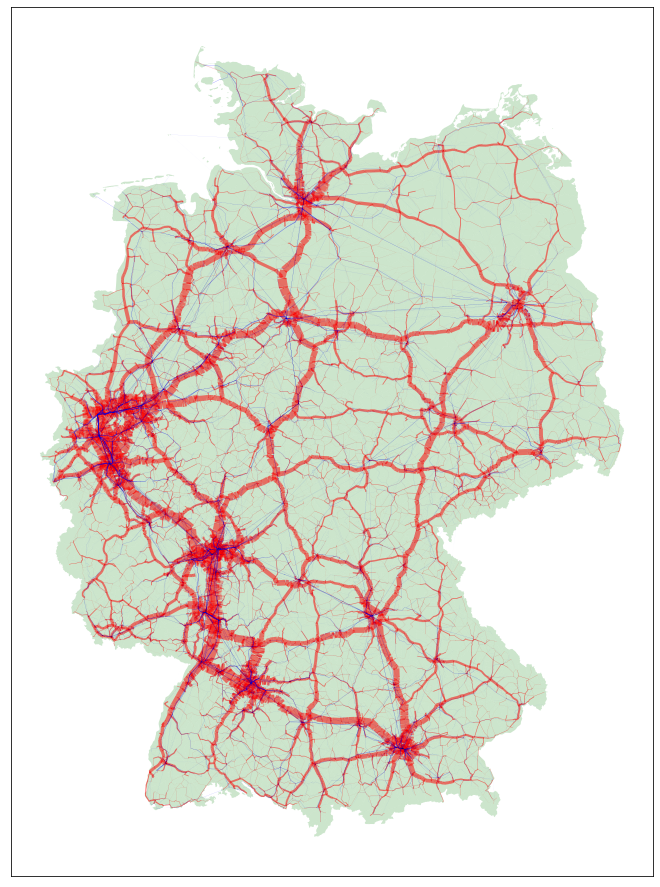

In [28]:
# Plot road and PT assignment
sm.links = gpd.GeoDataFrame(sm.links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.links['volume'].max(), sm.road_links[('volume', 'car')].max()) / 35
sm.links.loc[sm.links['volume'].notna(), ['geometry']
            ].plot(alpha=.3, color='blue',
                   linewidth=list(sm.links.loc[sm.links['volume'].notna(), 'volume']/scaler),
    ax=sm.road_links.loc[sm.road_links[('volume', 'car')].notna(), ['geometry']
                        ].plot(alpha=.3, color='red',
                               linewidth=list(sm.road_links.loc[sm.road_links[('volume', 'car')].notna()][('volume', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
plt.savefig(output_path + scenario + '/' + 'network_load_all.png', dpi=300)

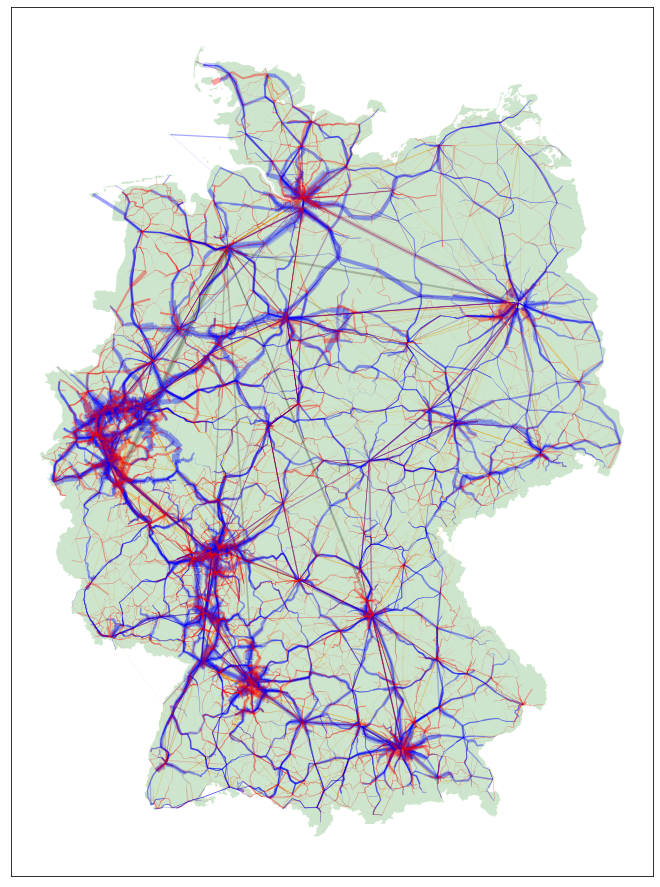

In [29]:
# Only PT
colors = sm.links['route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.links.loc[sm.links['volume'].notna(), ['geometry']].plot(
    alpha=.2, color=list(colors),
    linewidth=list(sm.links.loc[sm.links['volume'].notna(),'volume']
                   /sm.links.loc[sm.links['volume'].notna(),'volume'].max()*35),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_pt.png', dpi=300)

### Validation

In [30]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

<AxesSubplot:>

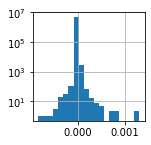

In [31]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [22]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments].sum()
for purpose in purposes:
    od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg.split('_')[0]==purpose]].sum(axis=1)
od_sum.drop(sm.segments, axis=1, inplace=True)
od_sum['root'] = od_sum.sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [23]:
od_sum.sample()

,,segment,commuting,business,education,buy/execute,leisure,accompany,root
,,sum,volume,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,,
DEA28_2,DE128_6,car,0.0,7.458649,0.0,0.0,43.434283,10.57389,61.466822


In [24]:
# Add averages from following attributes
attrs = ['time', # hours per trip
         #'in_vehicle_time', # seconds per ride
         #'waiting_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type']).mean()[attrs]
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [25]:
# Convert units
od_sum[('root', 'length')] /= 1000
#od_sum[('root', 'in_vehicle_time')] /= 3600
#od_sum[('root', 'waiting_time')] /= 3600

In [26]:
# Compute passenger kilometer
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [27]:
# Load calibration dataset for modal split validation
mid_val = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid_val.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid_val['mode_agg'] = [mode_dict_mid[i] for i in mid_val.index]

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='business'>,
       <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='buy/execute'>, <AxesSubplot:ylabel='leisure'>,
       <AxesSubplot:ylabel='accompany'>], dtype=object)

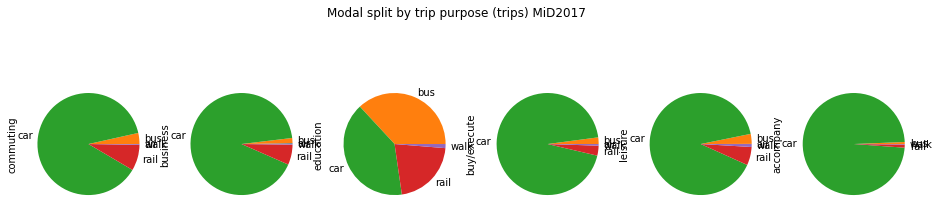

In [28]:
mid_val.groupby('mode_agg').sum()[purposes].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

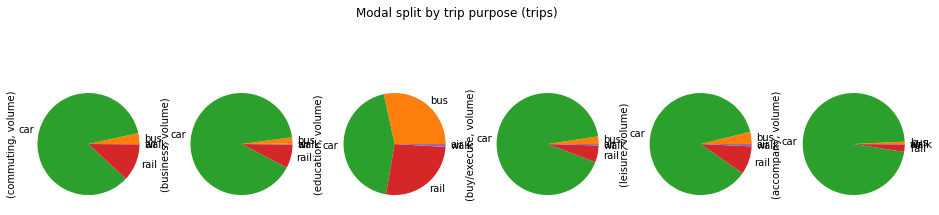

In [29]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [30]:
# MiD mode shares in percent
(mid_val.groupby('mode_agg').sum() /
 mid_val[purposes].sum() * 100)[purposes].round(2)

,commuting,business,education,buy/execute,leisure,accompany
mode_agg,,,,,,
air,0.00,0.26,0.00,0.01,0.05,0.00
bus,3.49,1.64,36.90,2.09,3.15,0.64
car,88.03,91.52,40.39,94.24,90.08,98.22
rail,8.22,6.38,21.42,3.14,5.79,0.98
walk,0.26,0.20,1.29,0.53,0.93,0.16


In [31]:
# Model mode shares in percent
(od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum() /
 od_sum[[(seg, 'volume') for seg in purposes]].sum() * 100).round(2)

segment,commuting,business,education,buy/execute,leisure,accompany
sum,volume,volume,volume,volume,volume,volume
mode,,,,,,
air,0.00,0.10,0.00,0.00,0.02,0.00
bus,3.46,2.02,28.40,2.41,3.84,0.76
car,84.62,90.24,43.91,91.80,86.45,96.78
rail,11.81,7.47,26.79,5.33,8.96,2.33
walk,0.11,0.16,0.90,0.46,0.73,0.14


In [32]:
# MiD2017 mode shares - total
mid_val['sum'] = mid_val[purposes].sum(axis=1)
(mid_val.groupby('mode_agg').agg({'sum': 'sum'}) / mid_val['sum'].sum() * 100).round(2)

,sum
mode_agg,
air,0.03
bus,4.12
car,89.24
rail,6.03
walk,0.57


In [33]:
# Model mode shares in percent - total
(od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2)

sum,volume,time,length,ntransfers,pkm
mode,,,,,
air,0.02,6.84,9.11,12.04,0.19
bus,4.22,31.83,19.52,41.42,3.17
car,86.11,26.44,36.74,0.00,89.17
rail,9.25,34.85,34.62,46.54,7.36
walk,0.41,0.03,0.01,0.00,0.12


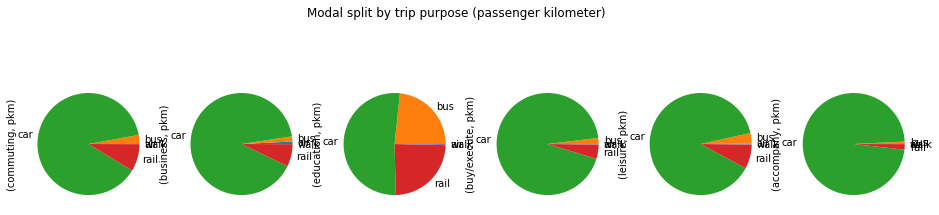

In [34]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [35]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [36]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

In [37]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
#sm.car_los['o'] = sm.car_los['origin'].replace(island_dict).str[:5]
#sm.car_los['d'] = sm.car_los['destination'].replace(island_dict).str[:5]
#distances_agg = sm.car_los.groupby(['o', 'd']).agg({'length': 'mean'}) / 1000
#distances_agg.index.set_names(['origin', 'destination'], inplace=True)
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [38]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left',
                             left_on=['origin', 'destination'],
                             right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left',
                                     left_index=True,
                                     right_index=True)['length'],
                        bins=bins, labels=labels)

In [39]:
p_dict = dict(zip(vp_purpose_dict.values(), vp_purpose_dict.keys()))

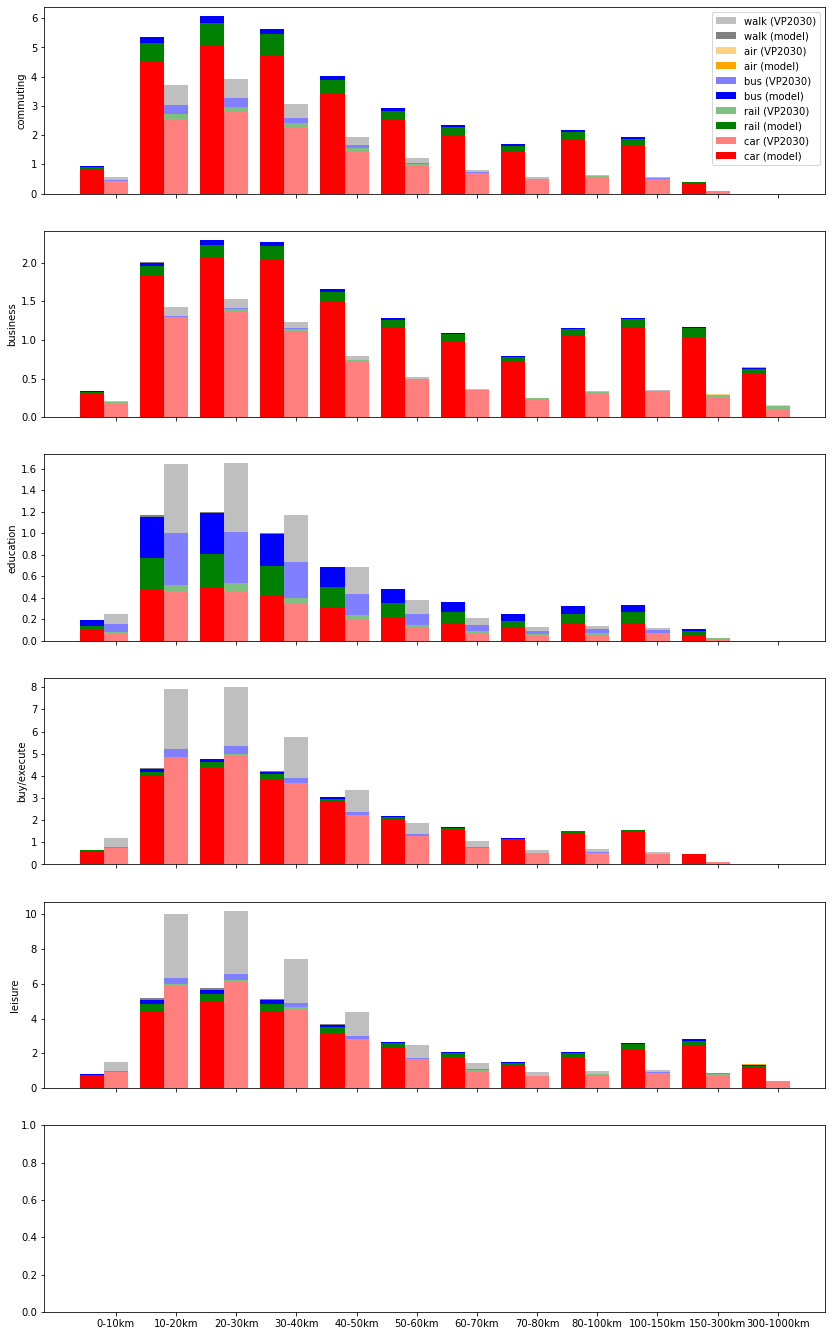

In [40]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
width = 0.4
ind = np.arange(len(labels))
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
for seg in range(len(purposes[:-1])):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    vp_vols = [vp_binned[(p_dict[purposes[seg]], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030.png', dpi=300)

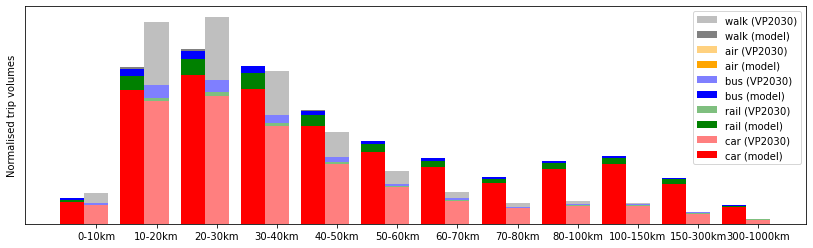

In [41]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        vp_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        vp_bottom = sum(vp_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, vp_vols[i], bottom=vp_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
ax.set_ylabel('Normalised trip volumes')
ax.set_yticks([])
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030_all.png', dpi=300)

In [42]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
'''    lau_nuts_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
    mid2017['origin'] = mid2017['origin'].astype(str).map(lau_nuts_dict)
    mid2017['destination'] = mid2017['destination'].astype(str).map(lau_nuts_dict)
    # Drop all other trips
    mid2017 = mid2017.loc[(mid2017['origin'].notna()) & (mid2017['destination'].notna())]'''
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])

In [43]:
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']
                                     ).index.map(distances.to_dict()['length'])
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_model']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [44]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean()
                     / mid2017.mean().mean())

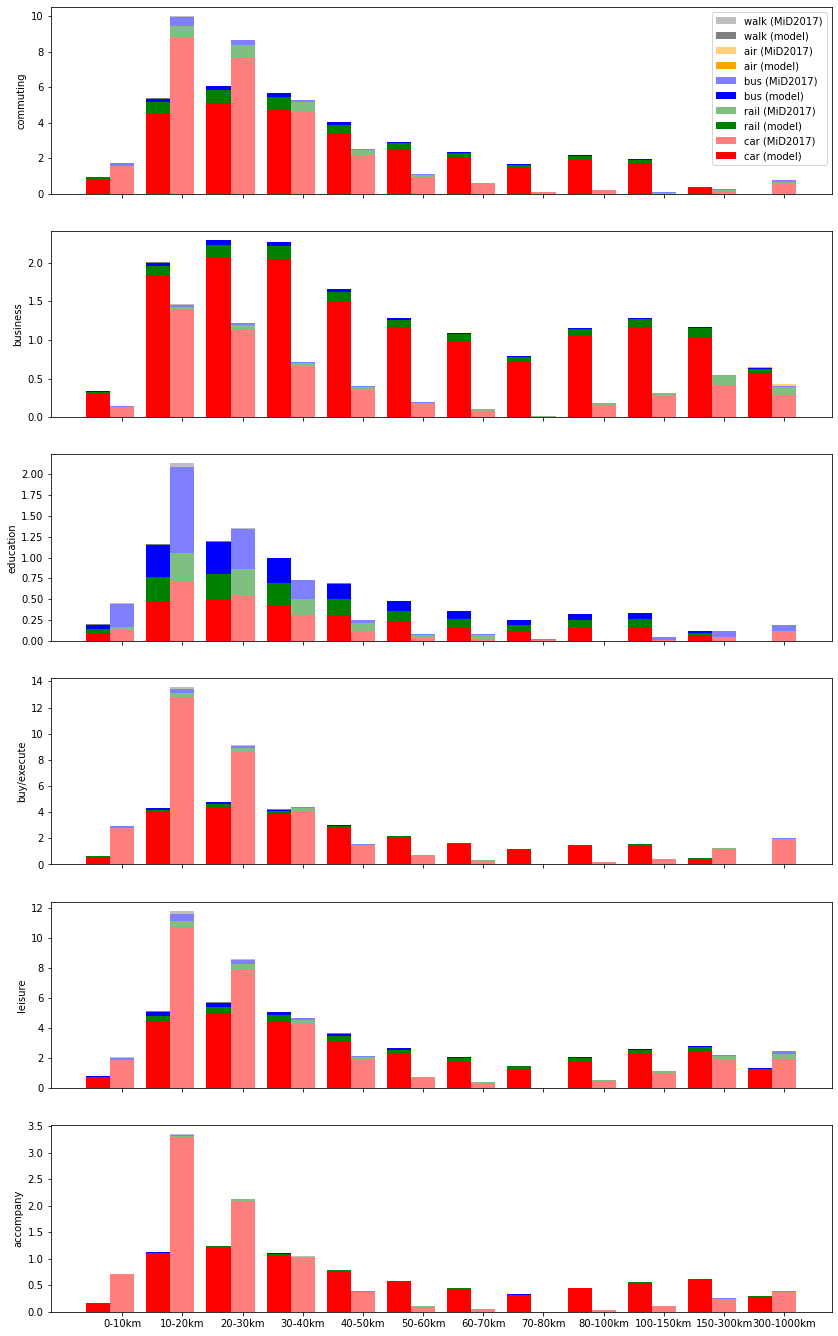

In [45]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(purposes[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=300)

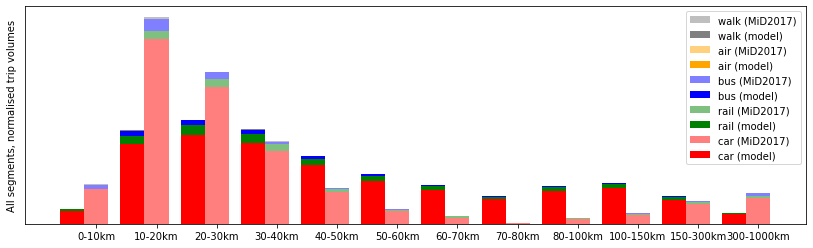

In [46]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
width = 0.4
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        mid_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
ax.set_ylabel('All segments, normalised trip volumes')
ax.set_yticks([])
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=300)

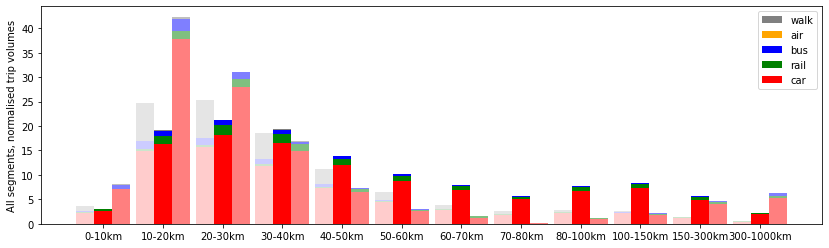

In [47]:
# Plot distance and mode distribution for all three data sources
fig, ax = plt.subplots(figsize=(14,4))
width = 0.3
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        vp_bottom = 0
        model_bottom = 0
        mid_bottom = 0
    else:
        vp_bottom = sum(vp_vols[:i])
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind-width, vp_vols[i], bottom=vp_bottom, alpha=.2,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i])#+' (model)')
ax.set_ylabel('All segments, normalised trip volumes')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-3], l[::-3])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_VP2030_all.png', dpi=300)

In [48]:
# Difference in the largest distance segment in % to MiD2017
(sum(model_vols.T[-1]) - sum(mid_vols.T[-1])) / sum(mid_vols.T[-1])

-0.6328942909500153

In [53]:
od_sum.xs('car', level=2)[('root', 'volume')].sum() / 1e6

16184.052585045696

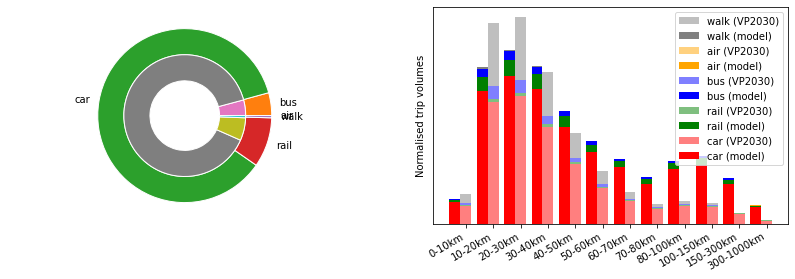

In [89]:
# Figure for publication
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

# double ring: Mode split model vs. MiD2017
ax[0].axis('equal')
width = 0.3
model_values = od_sum[('root', 'volume')].groupby(level=2).sum()
pie, _ = ax[0].pie(model_values,
                   radius=1, labels=model_values.index)
plt.setp( pie, width=width, edgecolor='white')
pie2, _ = ax[0].pie(mid_val.groupby('mode_agg').sum()[purposes].sum(axis=1),
                    radius=1-width, labeldistance=0.7)
plt.setp( pie2, width=width, edgecolor='white')

# Bar plot: Volumes by distance class model vs. VP2030
width = 0.4
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        vp_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        vp_bottom = sum(vp_vols[:i])
    ax[1].bar(ind, model_vols[i], bottom=model_bottom,
              width=width, tick_label=labels,
              color=colors[i], label=modes[i]+' (model)')
    ax[1].bar(ind+width, vp_vols[i], bottom=vp_bottom, alpha=.5,
              width=width, tick_label=labels, color=colors[i],
              label=modes[i]+' (VP2030)')
ax[1].set_ylabel('Normalised trip volumes')
ax[1].set_yticks([])
ax[1].set_xticklabels(labels, rotation=30, ha='right')
h, l = ax[1].get_legend_handles_labels()
ax[1].legend(h[::-1], l[::-1])

# Traffic map with MIT and PT
#plt.savefig(output_path + scenario + '/' + 'distance_mode-shares_validation.png', dpi=400)

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [60]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [61]:
# Aggregated modal split in million pkm by main mode
od.groupby(level=2).sum()['pkm'] / 1e6

mode
air       2063.093000
bus      34988.497180
car     985293.749689
rail     81279.349750
walk      1291.626288
Name: pkm, dtype: float64

In [62]:
# Aggregated pkm (million)
od.groupby(level=2).sum()['pkm'].sum() / 1e6

1104916.3159070972

In [63]:
# Total volumes between model zones (million)
sm.los['volume'].sum()/1e6

18795.67371550776

In [64]:
# Volumes between NUTS3-level (million)
sm.los.loc[sm.los['origin'].str[:5]!=sm.los['destination'].str[:5], 'volume'].sum() / 1e6

15701.892171824471

In [65]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [66]:
# Calculate weighted averages by zone aggregation
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    time=('time', weighted_av),
    #in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av))

## Save model

In [67]:
with pd.ExcelWriter(output_path + scenario + '/' + 'inter_zone.xlsx') as writer:
    od.to_excel(writer, sheet_name='od')

In [68]:
sm.to_json(model_path + 'de_assignment', only_attributes=[
    'links', 'nodes', 'road_links', 'volumes'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 18/18 [07:51<00:00, 26.21s/it]


In [ ]:
# Save distances between centroids
(car.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
).astype(int).to_csv(output_path + 'distances_centroids.csv')